Importamos las librerias

In [2]:
%load_ext lab_black

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from pycaret.classification import (
    add_metric,
    setup,
    compare_models,
    models,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_regression, f_regression, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    auc,
    average_precision_score,
    balanced_accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz


RANDOM_STATE = 42

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [3]:
def result_modelos_clasif(models, X_test, y_test, y_pred, y_proba):
    print(models[1])
    # print(classification_report(y_test,y_pred))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    fig.tight_layout(w_pad=2)

    cm = confusion_matrix(y_test, y_pred)
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_disp.plot(ax=ax1)

    fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    print("Area bajo la curva ROC:", np.round(roc_auc_score(y_test, y_proba[:, 1]), 4))
    roc_disp.plot(ax=ax2)

    precision, recall, threshold = precision_recall_curve(y_test, y_proba[:, 1])
    pr_disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    print("Area bajo la curva Precision-Recall:", np.round(auc(recall, precision), 4))
    pr_disp.plot(ax=ax3)
    print("\n")


def select_features_mutual_info(X_train, y_train, k="all"):
    fs = SelectKBest(score_func=mutual_info_regression, k=k)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    return X_train_fs, fs


def select_features_pearson(X_train, y_train, k="all"):
    fs = SelectKBest(score_func=f_regression, k=k)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    return X_train_fs, fs

Cargamos el dataset

In [4]:
df_original = pd.read_csv(
    "/tf/notebooks/CEIA-machine_learning/tp-grupal/HR-Employee-Attrition.csv"
)
# df_original = pd.read_csv("HR-Employee-Attrition.csv")
df = df_original.copy()

print(f"El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas")

El dataset tiene 1470 filas y 35 columnas


Observamos las primeras columnas del dataset

In [5]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


Y los tipos de los objetos

In [6]:
df.dtypes

Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears   

### Variables Categóricas

Las variables categóricas son:
- Attrition
- BusinessTravel
- Department
- Education
- EducationField
- EmployeeCount
- EnvironmentSatisfaction
- Gender
- JobInvolvement
- JobLevel
- JobRole
- JobSatisfaction
- MaritalStatus
- Over18
- OverTime
- PerformanceRating
- RelationshipSatisfaction
- StandardHours
- StockOptionLevel
- WorkLifeBalance

In [7]:
categorical_variables = [
    "Attrition",
    "BusinessTravel",
    "Department",
    "Education",
    "EducationField",
    "EmployeeCount",
    "EnvironmentSatisfaction",
    "Gender",
    "JobInvolvement",
    "JobLevel",
    "JobRole",
    "JobSatisfaction",
    "MaritalStatus",
    "Over18",
    "OverTime",
    "PerformanceRating",
    "RelationshipSatisfaction",
    "StandardHours",
    "StockOptionLevel",
    "WorkLifeBalance",
]

for variable in categorical_variables:
    print(f"Ocurrencia dentro de {variable}")
    print(df[variable].value_counts(normalize=True))
    print()

Ocurrencia dentro de Attrition
No     0.838776
Yes    0.161224
Name: Attrition, dtype: float64

Ocurrencia dentro de BusinessTravel
Travel_Rarely        0.709524
Travel_Frequently    0.188435
Non-Travel           0.102041
Name: BusinessTravel, dtype: float64

Ocurrencia dentro de Department
Research & Development    0.653741
Sales                     0.303401
Human Resources           0.042857
Name: Department, dtype: float64

Ocurrencia dentro de Education
3    0.389116
4    0.270748
2    0.191837
1    0.115646
5    0.032653
Name: Education, dtype: float64

Ocurrencia dentro de EducationField
Life Sciences       0.412245
Medical             0.315646
Marketing           0.108163
Technical Degree    0.089796
Other               0.055782
Human Resources     0.018367
Name: EducationField, dtype: float64

Ocurrencia dentro de EmployeeCount
1    1.0
Name: EmployeeCount, dtype: float64

Ocurrencia dentro de EnvironmentSatisfaction
3    0.308163
4    0.303401
2    0.195238
1    0.193197
Name:

Se observan dos datos importantes:
- La variable a predecir Attrition se encuentra desbalanceada.
- Las variables EmployeeCount, Over18 y StandardHours son constantes, por lo tanto no aportan información. Se decide eliminarlas.

In [8]:
constant_variables = ["EmployeeCount", "Over18", "StandardHours"]
df.drop(constant_variables, axis=1, inplace=True)

Dentro de las variables categoricas listadas arriba, no encontramos ninguna que tenga una relacion ordinal, de manera que podemos hacer un One-Hot encoding sobre las mismas. Ademas pasamos de categorica a numerica aquellas que tengan solo 2 valores posibles.

In [9]:
df["Attrition"] = df["Attrition"].replace(to_replace=["No", "Yes"], value=[0, 1])
df["OverTime"] = df["OverTime"].replace(to_replace=["No", "Yes"], value=[0, 1])
df["Gender"] = df["Gender"].replace(to_replace=["Male", "Female"], value=[0, 1])

### Variables Numéricas

Vemos un resumen de las características más importantes de las variables numéricas

In [10]:
for variable in constant_variables:
    categorical_variables.remove(variable)

df_numerical = df.drop(columns=categorical_variables, axis=1)
df_numerical.describe()

,Age,DailyRate,DistanceFromHome,EmployeeNumber,HourlyRate,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,1024.865306,65.891156,6502.931293,14313.103401,2.693197,15.209524,11.279592,2.799320,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,602.024335,20.329428,4707.956783,7117.786044,2.498009,3.659938,7.780782,1.289271,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,30.000000,1009.000000,2094.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,491.250000,48.000000,2911.000000,8047.000000,1.000000,12.000000,6.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,1020.500000,66.000000,4919.000000,14235.500000,2.000000,14.000000,10.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,1555.750000,83.750000,8379.000000,20461.500000,4.000000,18.000000,15.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,2068.000000,100.000000,19999.000000,26999.000000,9.000000,25.000000,40.000000,6.000000,40.000000,18.000000,15.000000,17.000000


Verificamos valores nulos

In [11]:
df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

In [12]:
df.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

Graficamos los histogramas de las variables numericas

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


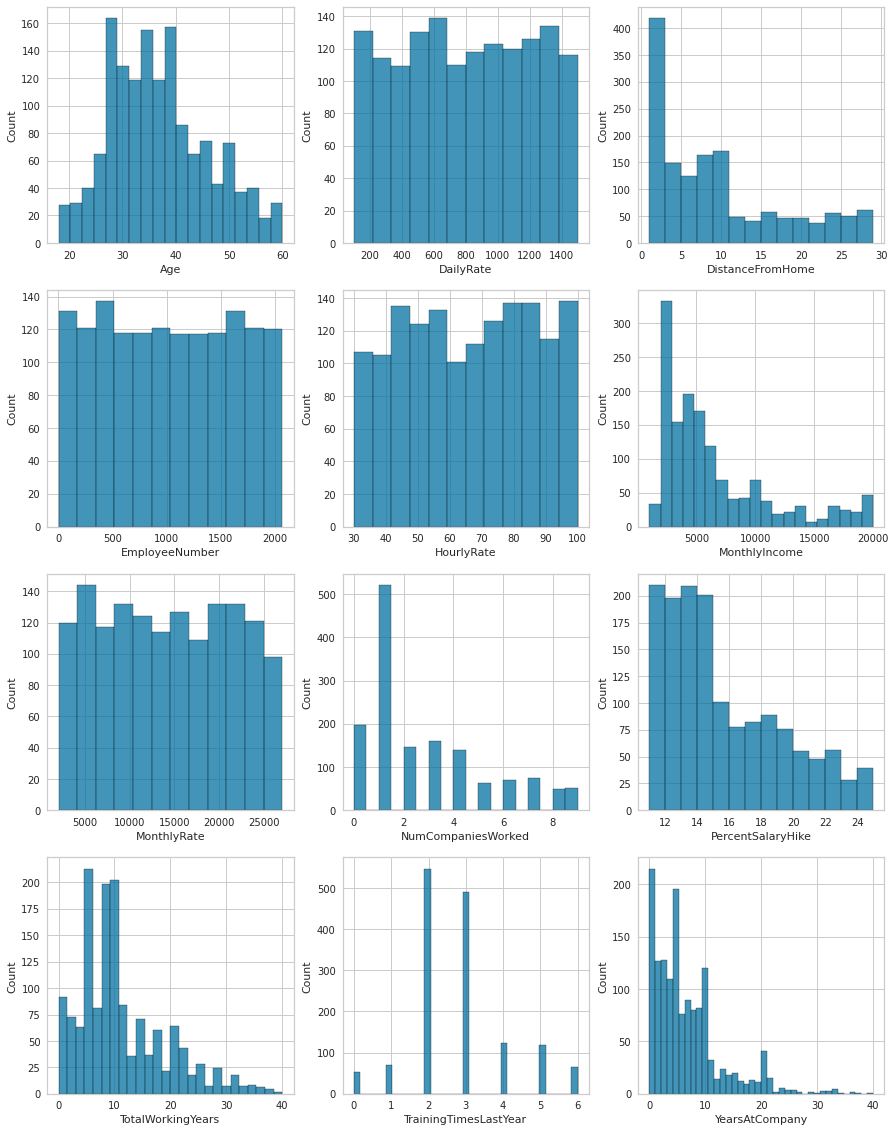

In [13]:
f, axes = plt.subplots(4, 3, figsize=(15, 20))
for ax, feature in zip(axes.flat, df_numerical.columns):
    sns.histplot(df_numerical[feature], ax=ax, kde=False)

Vemos en los graficos que las variables "DailyRate", "EmployeeNumber", "HourlyRate", "MonthlyRate" son cuasi constantes, se decide eliminarlas.

In [14]:
df = df.drop(["DailyRate", "EmployeeNumber", "HourlyRate", "MonthlyRate"], axis=1)

Graficamos los boxplot de las variables numericas

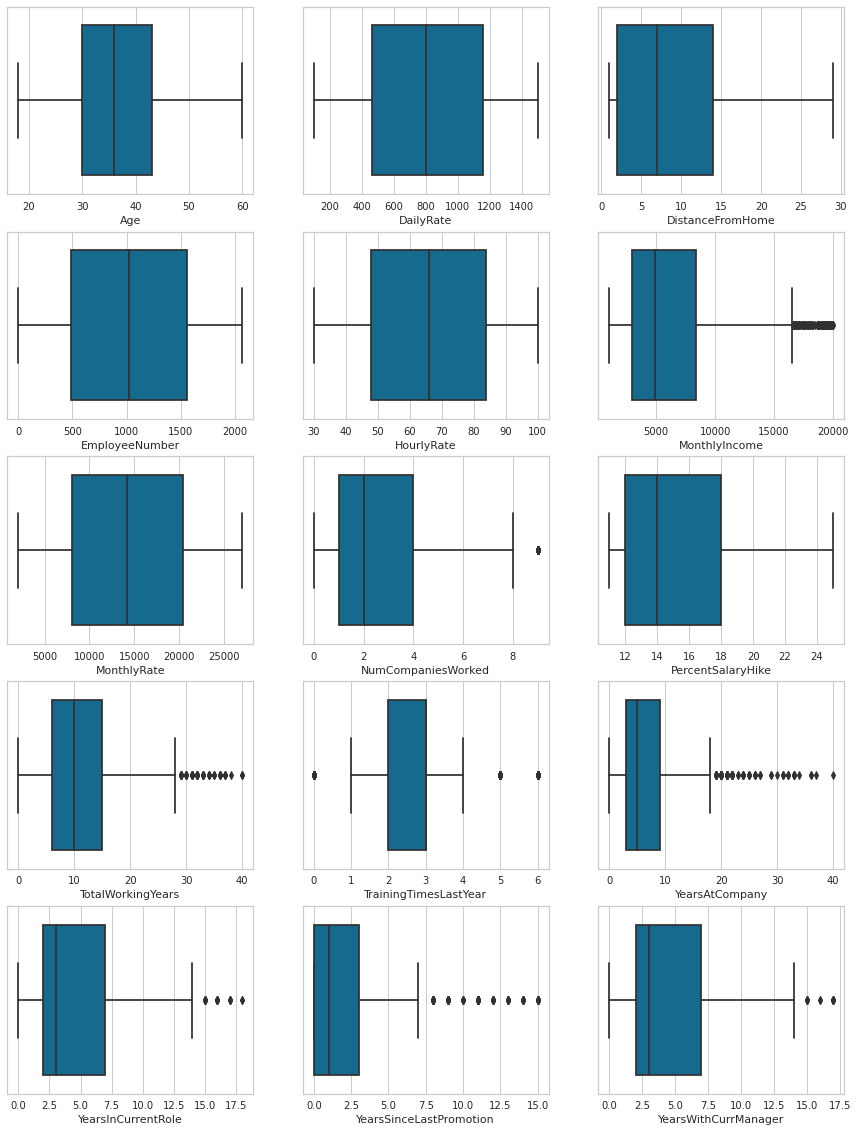

In [15]:
f, axes = plt.subplots(5, 3, figsize=(15, 20))
for ax, feature in zip(axes.flat, df_numerical.columns):
    sns.boxplot(x=df_numerical[feature], ax=ax)

Convertimos las variables categoricas en numericas

In [16]:
dfnew = pd.get_dummies(df)
dfnew
# dfnew.dtypes

,Age,Attrition,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,41,1,1,2,2,1,3,2,4,5993,8,1,11,3,1,0,8,0,1,6,4,0,5,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,49,0,8,1,3,0,2,2,2,5130,1,0,23,4,4,1,10,3,3,10,7,1,7,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,37,1,2,2,4,0,2,1,3,2090,6,1,15,3,2,0,7,3,3,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
3,33,0,3,4,4,1,3,1,3,2909,1,1,11,3,3,0,8,3,3,8,7,3,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,27,0,2,1,1,0,3,1,2,3468,9,0,12,3,4,1,6,3,3,2,2,2,2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,0,23,2,3,0,4,2,4,2571,4,0,17,3,3,1,17,3,3,5,2,0,3,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1466,39,0,6,1,4,0,2,3,1,9991,4,0,15,3,1,1,9,5,3,7,7,1,7,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1467,27,0,4,3,2,0,4,2,2,6142,1,1,20,4,2,1,6,0,3,6,2,0,3,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1468,49,0,2,3,4,0,2,2,2,5390,2,0,14,3,4,0,17,3,2,9,6,0,8,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


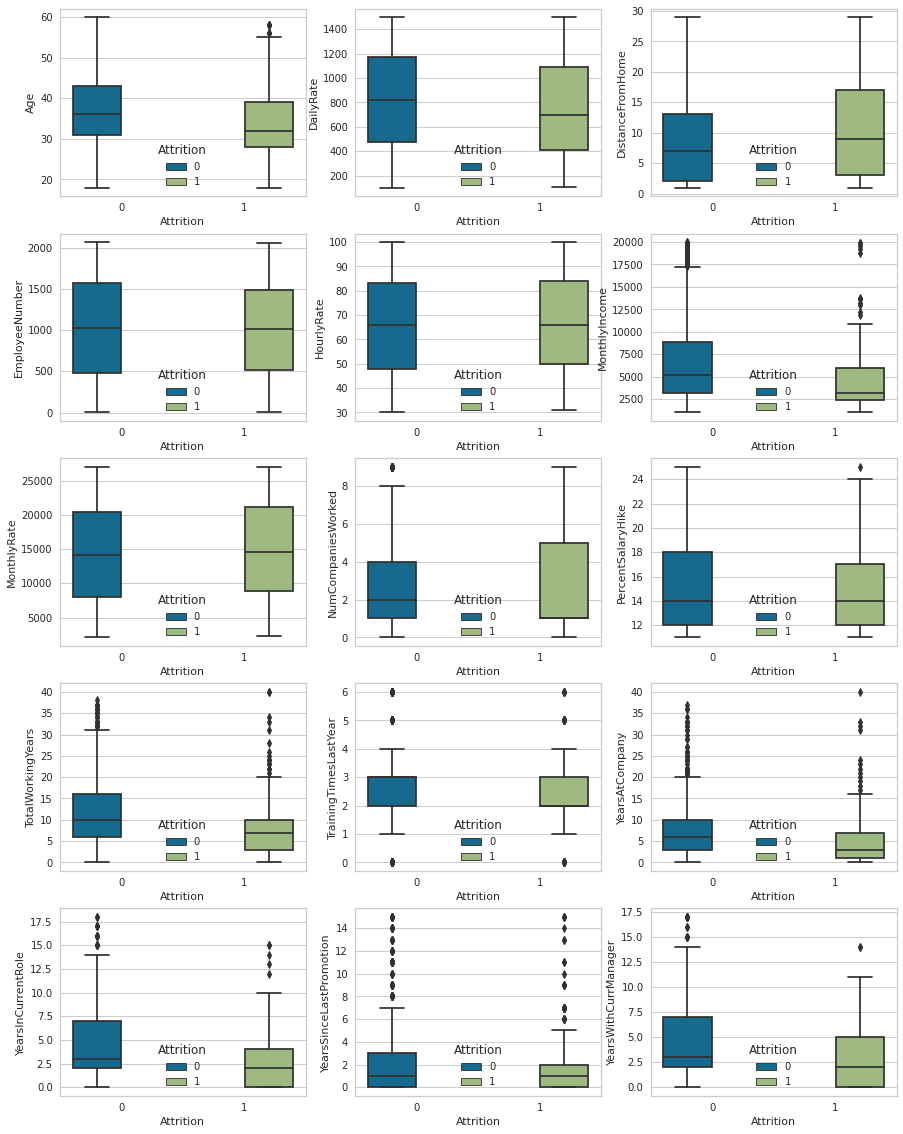

In [17]:
f, axes = plt.subplots(5, 3, figsize=(15, 20))
for ax, feature in zip(axes.flat, df_numerical.columns):
    sns.boxplot(
        x=dfnew["Attrition"],
        y=df_numerical[feature],
        hue=dfnew["Attrition"],
        data=dfnew,
        ax=ax,
    )

**Modelos y funciones**

<AxesSubplot:>

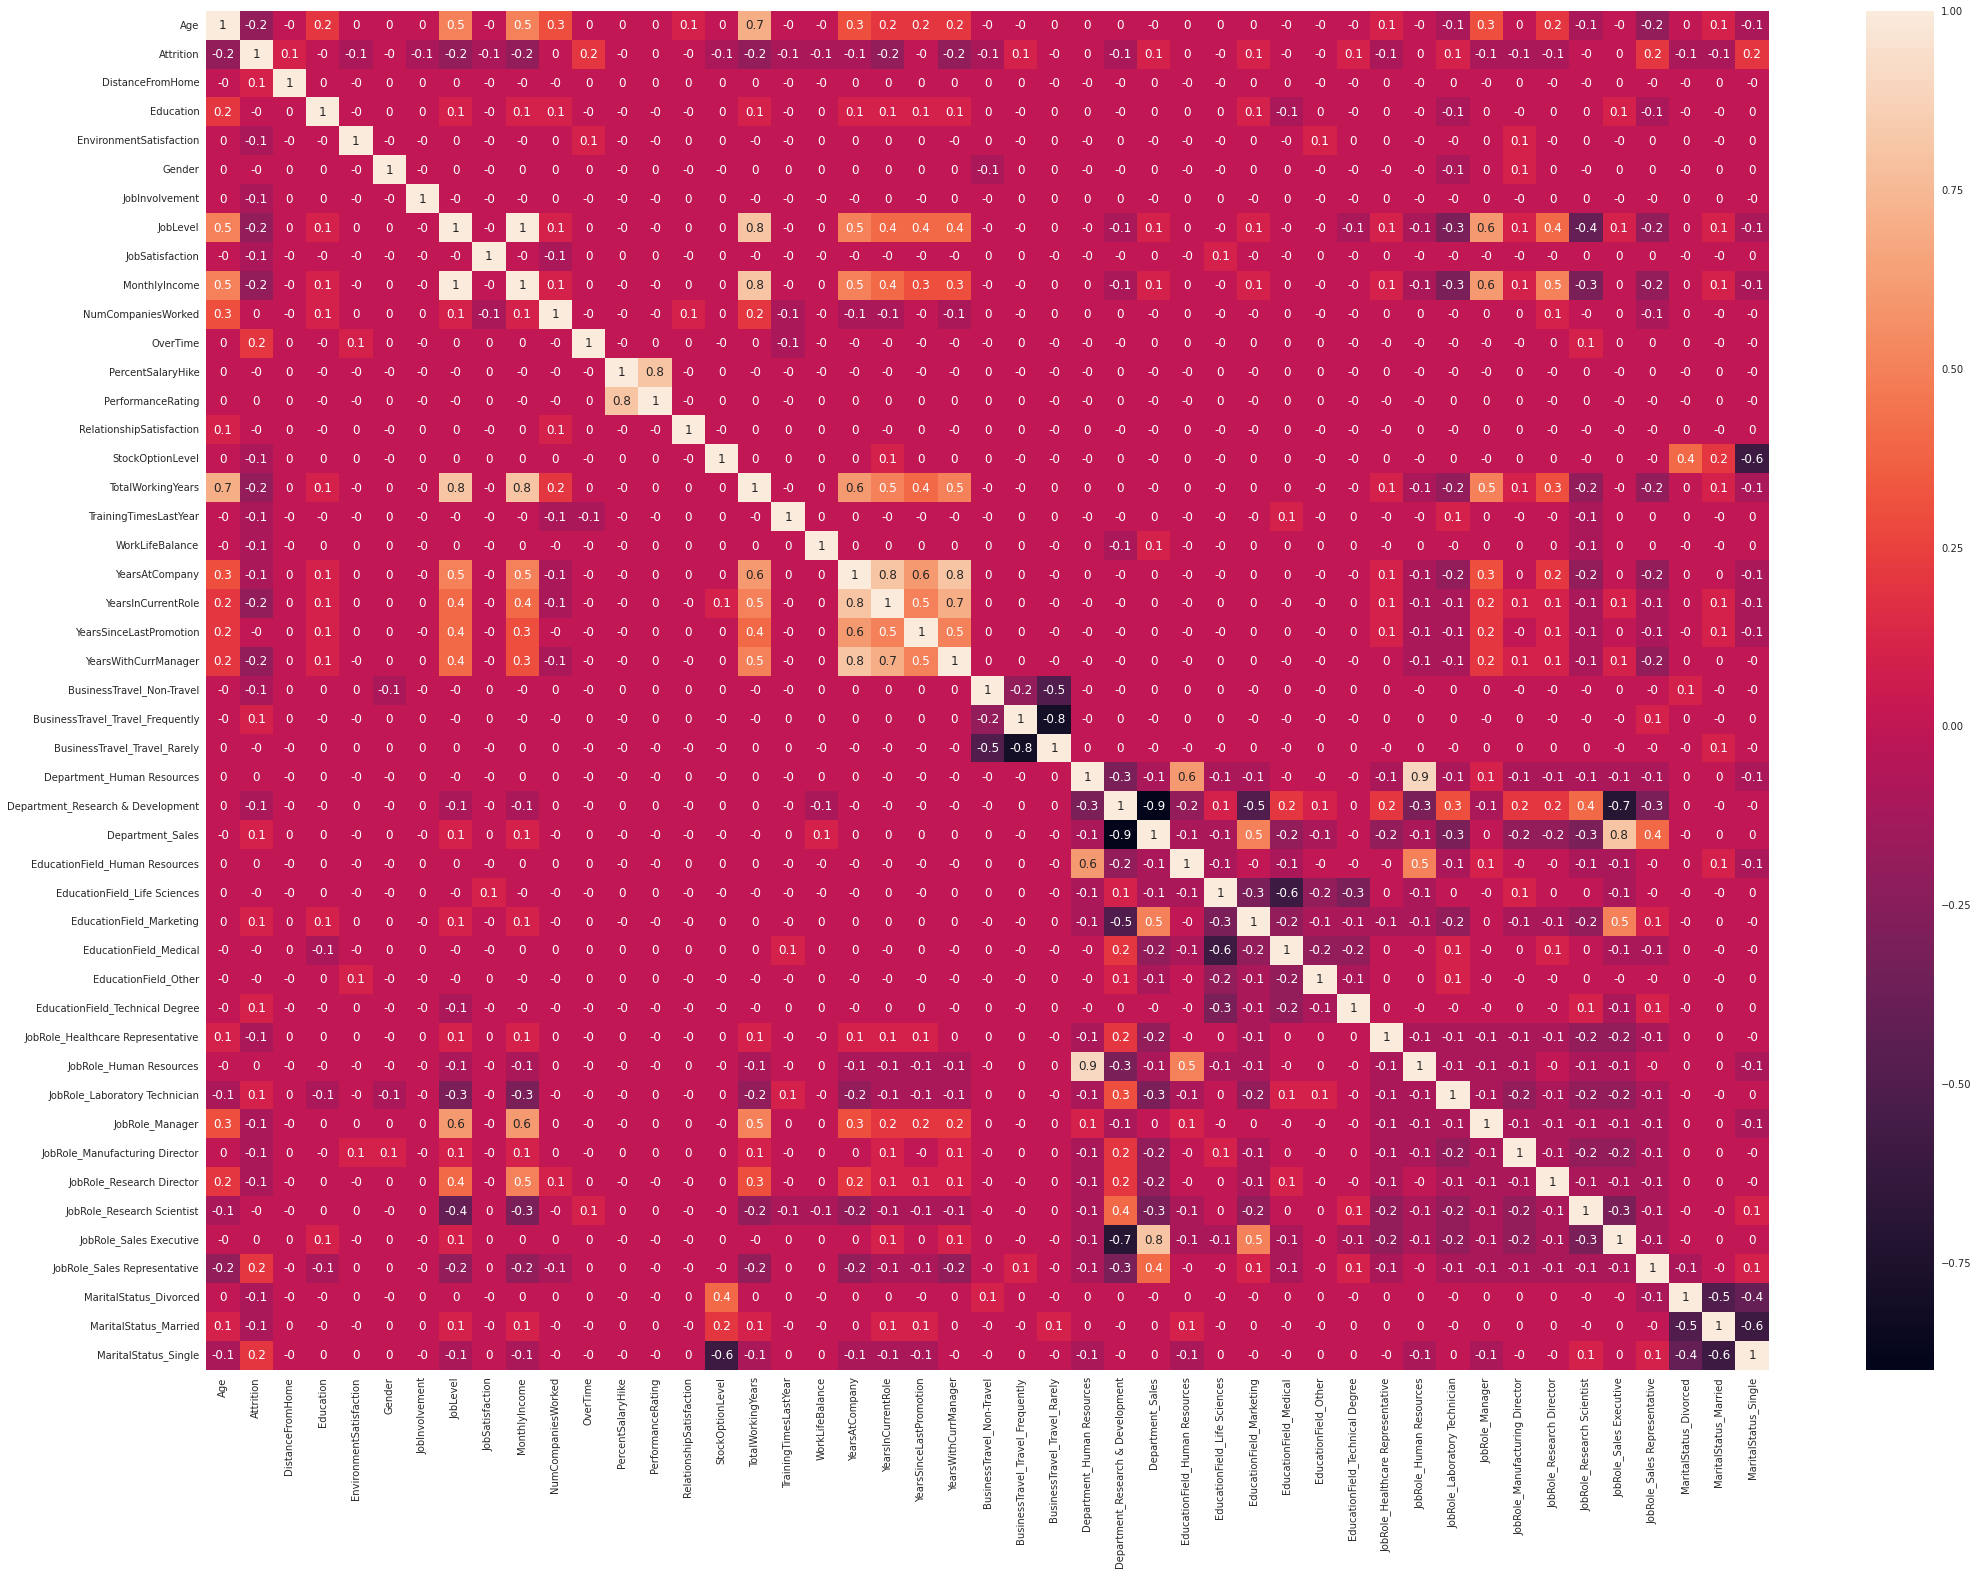

In [18]:
corr_mat_pearson = dfnew.corr(method="pearson").round(1)
fig, axes = plt.subplots(1, 1, figsize=(35, 25))
sns.heatmap(data=corr_mat_pearson, annot=True, ax=axes)

Definimos la variable objetivo

In [19]:
# Definimos la variable objetivo a predecir (y) y las feature (X)
y = dfnew["Attrition"]
X = dfnew.drop("Attrition", axis=1)

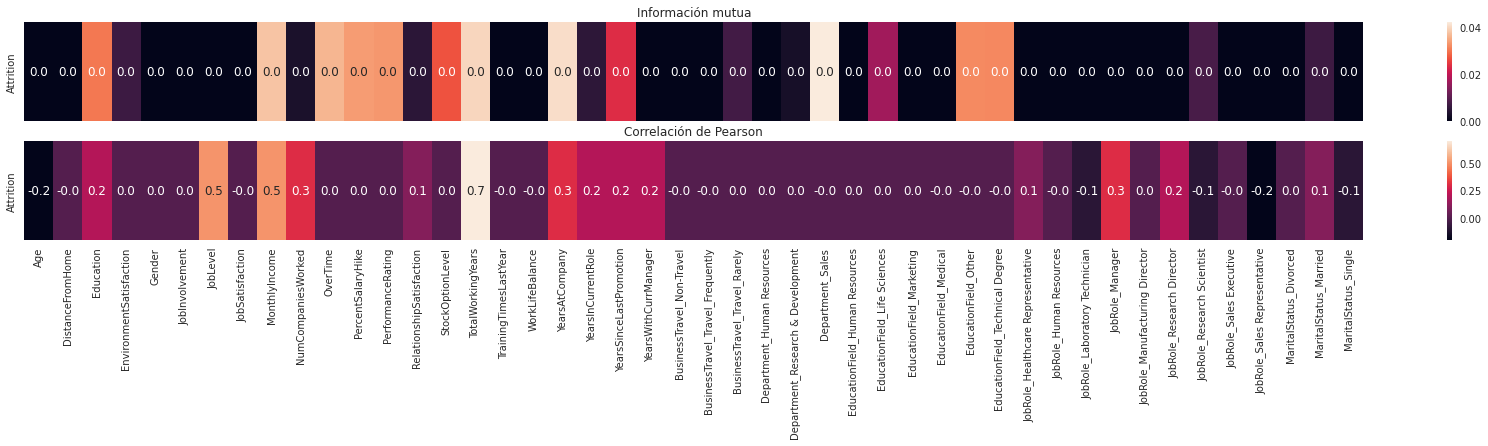

In [20]:
mutual_info = mutual_info_regression(X, y)
fig, ax = plt.subplots(2, 1, figsize=(30, 4))
sns.heatmap([mutual_info], ax=ax[0], annot=True, fmt=".1f")
ax[0].set_title("Información mutua")
ax[0].set_xticklabels([])
ax[0].set_yticklabels(["Attrition"])

sns.heatmap([corr_mat_pearson.iloc[0][1:]], ax=ax[1], annot=True, fmt=".1f")
ax[1].set_title("Correlación de Pearson")
ax[1].set_xticklabels(X.columns, rotation=90)
ax[1].set_yticklabels(["Attrition"])
print()

Se utilizará pycaret para probar como funcionan distintos modelos. Se utiliza la función *'setup'* para realizar un preprocesaimento de los datos. A continuación se detallan el preprocesamiento a realizar.

- La variable target será la columna *'isFraud'*
- El 90% de los datos serán utilizados para entrenamiento y el 10% para test.
- Se normalizarán las variables utilizando el método *'zscore'*
- Se aplicará PCA y se seleccionarán las componentes que contengan el 90% de la varianza.
- Se removerán todas las componentes que presenten una correlación mayor a %90.
- Se balancean las clases utilizando el método *'SMOTE'*, que genera ejemplos sintéticos de la clase minoritaria.
- Se mezclan los datos aleatoriamente antes de dividir los sets de entrenamiento y test, a su vez esto se hace de manera estratificada para que haya igual cantidad de valores de las clases objetivo en cada conjunto de datos.
- Para el entrenamiento se utiliza una separácion *'k-fold'* de 5 folds.
- Se utiliza una semilla aleatoria concreta para poder reproducir el experimento.

In [21]:
clf1 = setup(
    df,
    target="Attrition",
    train_size=0.9,
    # preprocess = False,
    normalize=True,
    normalize_method="zscore",
    pca=True,
    pca_components=0.9,
    # # remove_outliers = True,
    # # outliters_threshold = 0.05,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.9,
    fix_imbalance=True,  # SMOTE method
    data_split_shuffle=True,
    data_split_stratify=True,
    fold_strategy="stratifiedkfold",
    fold=5,
    session_id=RANDOM_STATE,
    silent=True,
    log_experiment=True,
    experiment_name="fraud-detection-1",
    use_gpu=True,
)

,Description,Value
0,session_id,42
1,Target,Attrition
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(1470, 28)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,22
8,Ordinal Features,False
9,High Cardinality Features,False


Vemos que modelos de regresión pueden ser aplicados.

In [22]:
models()

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


Agregamos las métricas *Balanced Accuracy* y *Average Precision* a la lista de métricas para evaluar.

In [23]:
add_metric("balancedAccuracy", "Balanced Accuracy", balanced_accuracy_score)
add_metric("averagePrecision", "Average Precision", average_precision_score)

Name                                                 Average Precision
Display Name                                         Average Precision
Score Function       <function average_precision_score at 0x7fcca9d...
Scorer                            make_scorer(average_precision_score)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: averagePrecision, dtype: object

Entrenamos distintos modelos

In [24]:
best_model = compare_models(
    include=[
        "lr",  # Logistic Regression
        "knn",  # K-Nearest Neighbors
        "dt",  # Decision Tree Classifier
        "svm",  # SVM - Linear Kernel
        "rbfsvm",  # SVM - Radial Kernel
        "rf",  # Random Forest Classifier
        # RandomForestClassifier(n_estimators=10, random_state=RANDOM_STATE),
    ],
    fold=5,
    cross_validation=True,
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balanced Accuracy,Average Precision,TT (Sec)
rf,Random Forest Classifier,0.8541,0.7749,0.2631,0.6304,0.3643,0.2980,0.3376,0.6153,0.2833,0.4080
rbfsvm,SVM - Radial Kernel,0.8337,0.8299,0.6481,0.4904,0.5572,0.4576,0.4650,0.7587,0.3754,0.6820
lr,Logistic Regression,0.7952,0.8234,0.7236,0.4208,0.5312,0.4118,0.4374,0.7663,0.3499,0.0520
svm,SVM - Linear Kernel,0.7853,0.0000,0.6292,0.3954,0.4840,0.3576,0.3743,0.7223,0.3090,0.0380
dt,Decision Tree Classifier,0.7370,0.6139,0.4322,0.2890,0.3459,0.1896,0.1958,0.6139,0.2183,0.1200
knn,K Neighbors Classifier,0.5140,0.6782,0.7928,0.2197,0.3439,0.1230,0.1891,0.6266,0.2081,0.2560


Dividimos el dataset en train y test

In [25]:
# Dividimos el set de datos en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=23, stratify=y
)

print("Composición del training set:")
print(y_train.value_counts())
print("\nComposición del test set:")
print(y_test.value_counts())

Composición del training set:
0    986
1    190
Name: Attrition, dtype: int64

Composición del test set:
0    247
1     47
Name: Attrition, dtype: int64



Estandarizamos los datos

In [26]:
# Estandarizamos los datos
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

Random Forest
Area bajo la curva ROC: 0.8483
Area bajo la curva Precision-Recall: 0.6033


K-Nearest Neighbours
Area bajo la curva ROC: 0.7159
Area bajo la curva Precision-Recall: 0.4204


Decision Tree Classifier
Area bajo la curva ROC: 0.6612
Area bajo la curva Precision-Recall: 0.4662


Logistic Regression
Area bajo la curva ROC: 0.8671
Area bajo la curva Precision-Recall: 0.6673




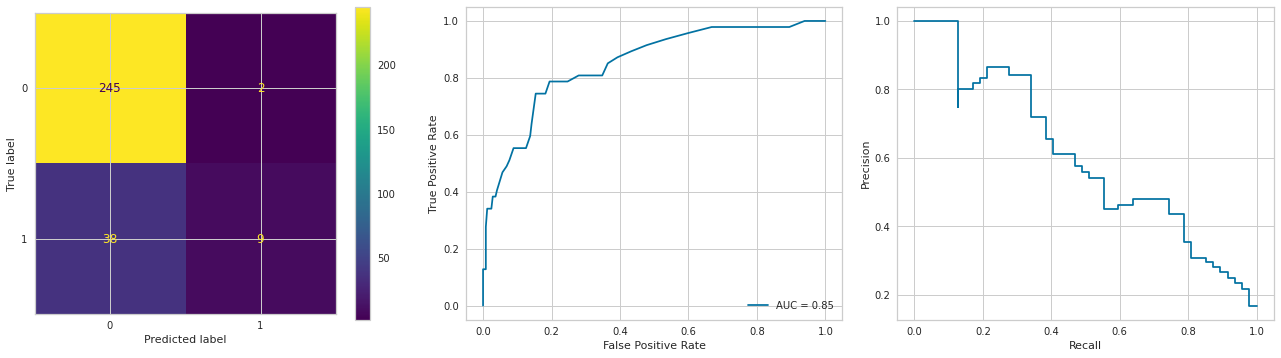

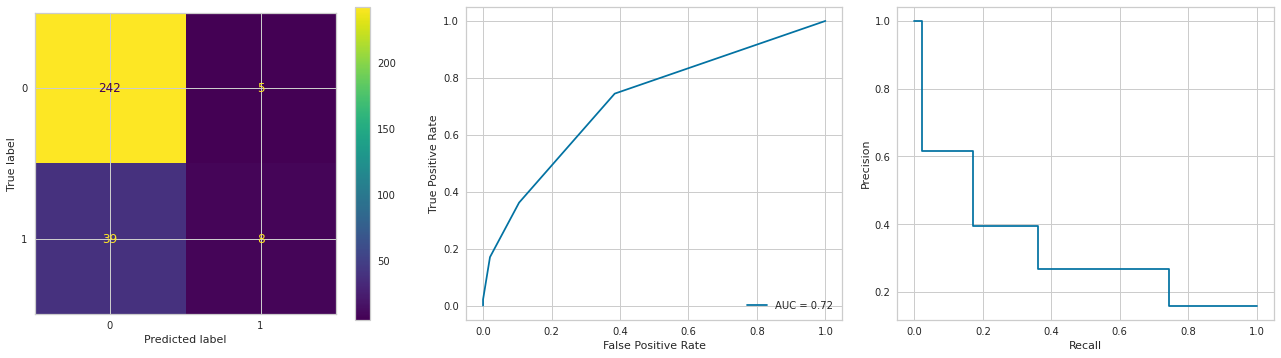

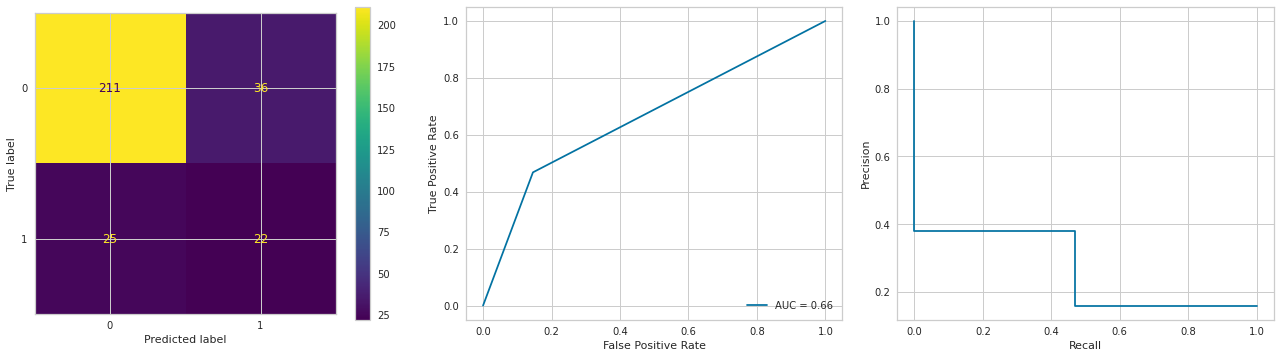

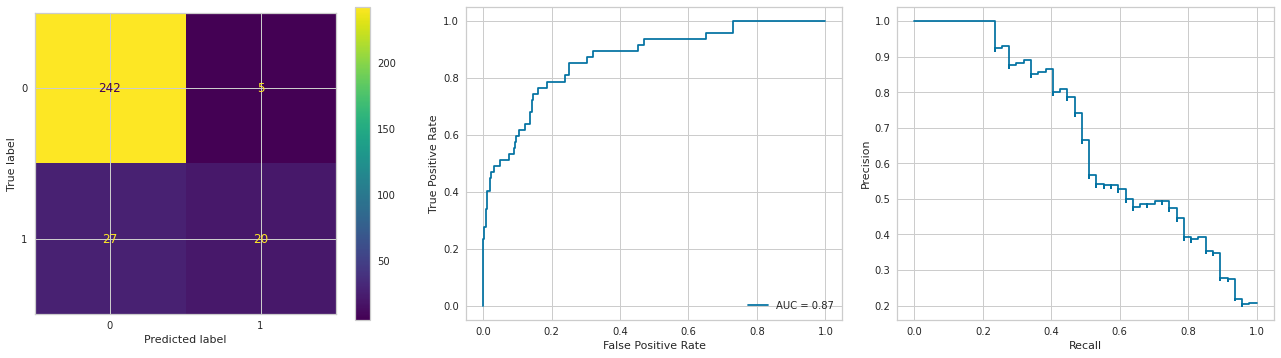

In [27]:
classifiers = [
    [RandomForestClassifier(), "Random Forest"],
    [KNeighborsClassifier(), "K-Nearest Neighbours"],
    [DecisionTreeClassifier(), "Decision Tree Classifier"],
    [LogisticRegression(), "Logistic Regression"],
]

for models in classifiers:
    model = models[0]
    model.fit(X_train_sc, y_train)

    y_pred = model.predict(X_test_sc)
    y_proba = model.predict_proba(X_test_sc)

    result_modelos_clasif(models, X_test_sc, y_test, y_pred, y_proba)

Generamos los datos de train con Undersampling

In [28]:
undersampler = RandomUnderSampler(sampling_strategy="majority")
X_train_us, y_train_us = undersampler.fit_resample(X_train_sc, y_train)
print("Composición del training set:")
print(y_train_us.value_counts())
print("\nComposición del test set:")
print(y_test.value_counts())

Composición del training set:
0    190
1    190
Name: Attrition, dtype: int64

Composición del test set:
0    247
1     47
Name: Attrition, dtype: int64


Random Forest
Area bajo la curva ROC: 0.4605
Area bajo la curva Precision-Recall: 0.1429


K-Nearest Neighbours
Area bajo la curva ROC: 0.4702
Area bajo la curva Precision-Recall: 0.2238


Decision Tree Classifier
Area bajo la curva ROC: 0.3331
Area bajo la curva Precision-Recall: 0.2462


Logistic Regression
Area bajo la curva ROC: 0.498
Area bajo la curva Precision-Recall: 0.0799




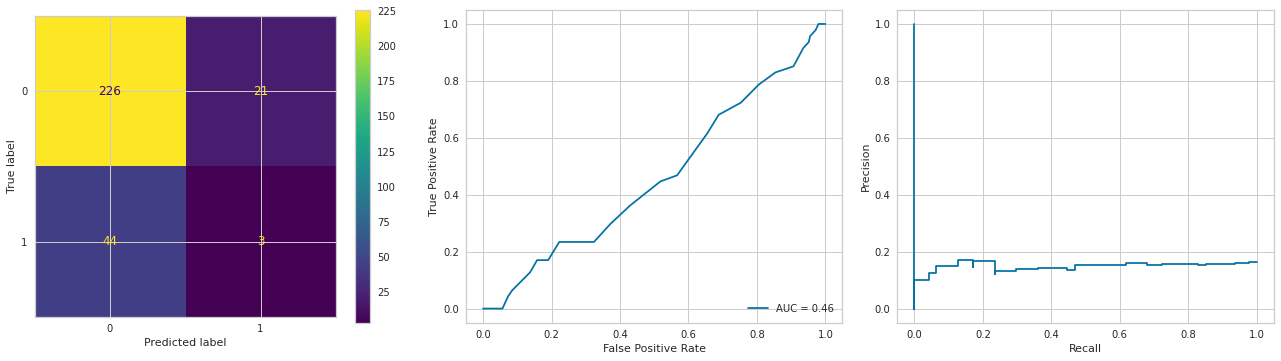

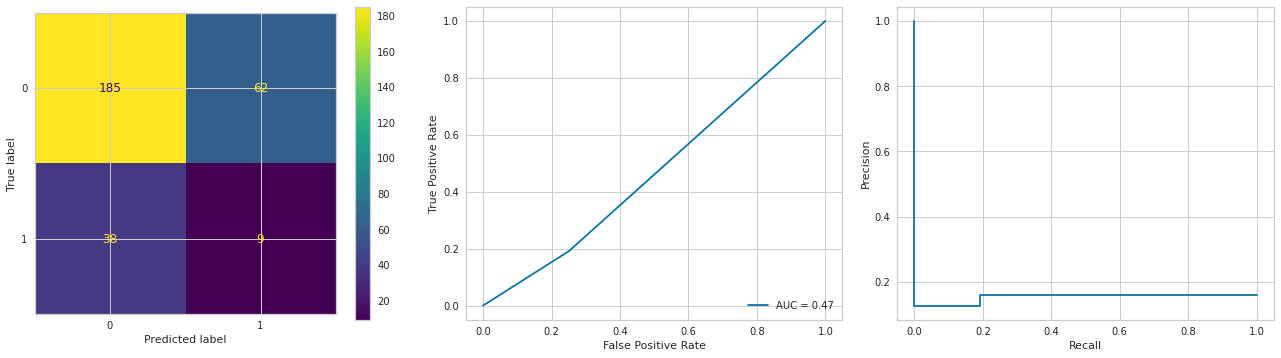

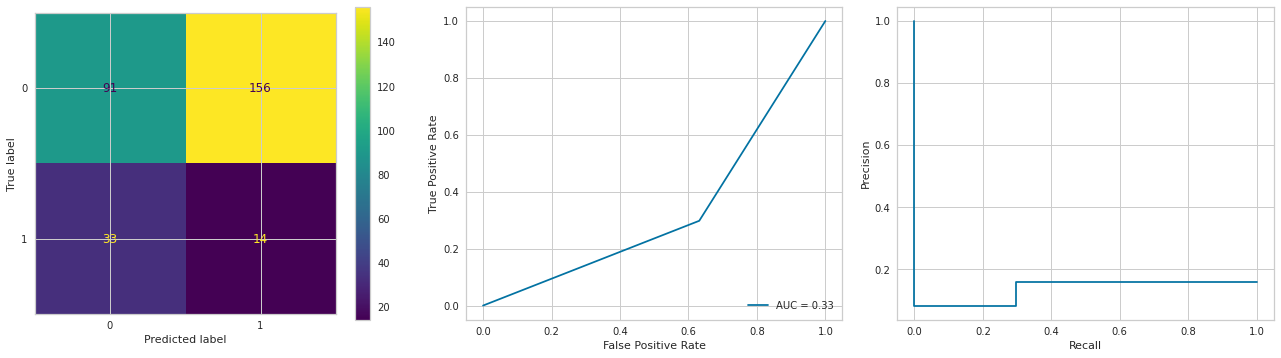

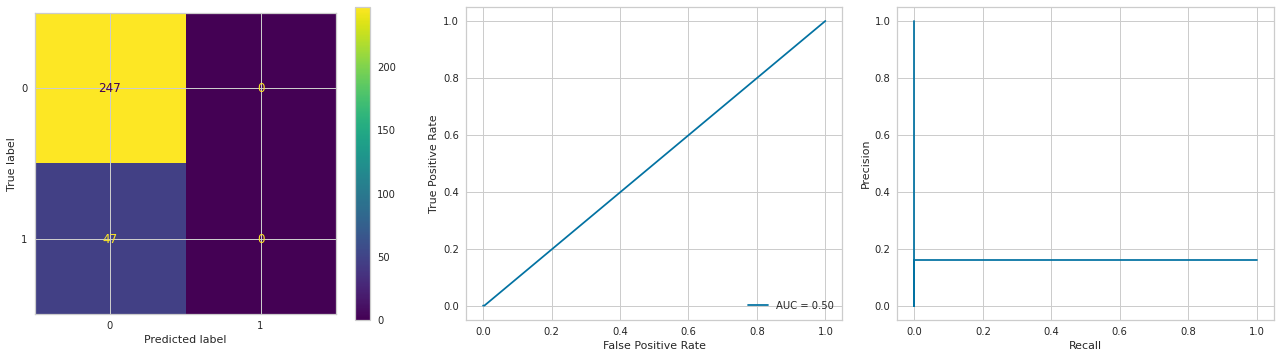

In [29]:
for models in classifiers:
    model = models[0]
    model.fit(X_train_us, y_train_us)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    result_modelos_clasif(models, X_test, y_test, y_pred, y_proba)

Generamos los datos de train con Oversampling

In [30]:
oversampler = RandomOverSampler(sampling_strategy="minority")
X_train_os, y_train_os = oversampler.fit_resample(X_train_sc, y_train)
print("Composición del training set:")
print(y_train_os.value_counts())
print("\nComposición del test set:")
print(y_test.value_counts())

Composición del training set:
0    986
1    986
Name: Attrition, dtype: int64

Composición del test set:
0    247
1     47
Name: Attrition, dtype: int64


In [31]:
DecisionTree(X_train_os, y_train_os, X_test_sc)  # Arbol de desicion - Oversampling

NameError: name 'DecisionTree' is not defined

In [ ]:
RandomForest(X_train_os, y_train_os, X_test_sc) # Random Forest - Oversampling

In [ ]:
RegresionLogistica(X_train_os, y_train_os, X_test_sc) # Regresion Logistica - Oversampling

In [ ]:
SVM(X_train_os, y_train_os, X_test_sc) # SVM - Oversampling

In [ ]:
# Saca un árbol del bosque
tree = rf.estimators_[1]

# Exportar la imagen a un archivo de puntos
export_graphviz(tree, out_file = 'tree.dot', feature_names = dfnew_list, rounded = True, precision = 1)

# Usamos dot file para crear el grafo
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Escribir el gráfico en un archivo png
graph.write_png('tree.png'); 

In [ ]:
print('La profundidad de este árbol es:', tree.tree_.max_depth)

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(dfnew_list, importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];